In [20]:
# Solution to bar challenge.
# Changed code lines 64 to 71

import pandas as pd
import plotly.express as px  # (version 4.7.0)

import dash  # (version 1.12.0) pip install dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

app = dash.Dash(__name__)

# ------------------------------------------------------------------------------
# Import and clean data (importing csv into pandas)
df = pd.read_csv("intro_bees.csv")

df = df.groupby(['State', 'ANSI', 'Affected by', 'Year', 'state_code'])[['Pct of Colonies Impacted']].mean()
df.reset_index(inplace=True)
print(df[:5])

# ------------------------------------------------------------------------------
# App layout
app.layout = html.Div([

    html.H1("Web Application Dashboards with Dash", style={'text-align': 'center'}),

    dcc.Dropdown(id="slct_year",
                 options=[
                     {"label": "2015", "value": 2015},
                     {"label": "2016", "value": 2016},
                     {"label": "2017", "value": 2017},
                     {"label": "2018", "value": 2018}],
                 multi=False,
                 value=2015,
                 style={'width': "40%"}
                 ),

    html.Div(id='output_container', children=[]),
    html.Br(),

    dcc.Graph(id='my_bee_map', figure={})

])


# ------------------------------------------------------------------------------
# Connect the Plotly graphs with Dash Components
@app.callback(
    [Output(component_id='output_container', component_property='children'),
     Output(component_id='my_bee_map', component_property='figure')],
    [Input(component_id='slct_year', component_property='value')]
)
def update_graph(option_slctd):
    print(option_slctd)
    print(type(option_slctd))

    container = "The year chosen by user was: {}".format(option_slctd)

    dff = df.copy()
    dff = dff[dff["Year"] == option_slctd]
    dff = dff[dff["Affected by"] == "Varroa_mites"]

    fig = px.bar(
        data_frame=dff,
        x='State',
        y='Pct of Colonies Impacted',
        hover_data=['State', 'Pct of Colonies Impacted'],
        labels={'Pct of Colonies Impacted': '% of Bee Colonies'},
        template='plotly_dark'
    )

    return container, fig


# ------------------------------------------------------------------------------
if __name__ == '__main__':
    app.run_server(debug=True)

C:\Users\svienne\AppData\Local\Temp\ipykernel_42324\3153359968.py:8: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

C:\Users\svienne\AppData\Local\Temp\ipykernel_42324\3153359968.py:9: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



     State  ANSI Affected by  Year state_code  Pct of Colonies Impacted
0  Alabama     1     Disease  2015         AL                      0.05
1  Alabama     1     Disease  2016         AL                      1.20
2  Alabama     1     Disease  2017         AL                      2.25
3  Alabama     1     Disease  2018         AL                      1.30
4  Alabama     1     Disease  2019         AL                      1.80


2015
<class 'int'>
2017
<class 'int'>


In [18]:
import plotly.express as px
px.set_mapbox_access_token(open(".mapbox_token").read())
df = px.data.carshare()
fig = px.scatter_mapbox(df, lat="centroid_lat", lon="centroid_lon",     color="peak_hour", size="car_hours",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig.show()

FileNotFoundError: [Errno 2] No such file or directory: '.mapbox_token'

In [9]:
from flask import Flask, render_template, request
import pandas as pd
import folium
from folium.plugins import MarkerCluster

app = Flask(__name__, template_folder='.')

# Définir la fonction sorted dans le contexte de rendu de modèle
@app.context_processor
def utility_processor():
    def custom_sorted(iterable):
        return sorted(iterable)
    return dict(sorted=custom_sorted)

# Votre code Flask continue ici...

# Charger les données
df_final = pd.read_csv(r"df_final.csv", low_memory=False)
df_final = df_final.dropna(subset=['latitude', 'longitude'])
df_final['latitude'] = pd.to_numeric(df_final['latitude'], errors='coerce')
df_final['longitude'] = pd.to_numeric(df_final['longitude'], errors='coerce')
df_final = df_final.dropna(subset=['latitude', 'longitude'])
df_final['type_operation'] = df_final['type_operation'].astype(str).replace('nan', 'Inconnu')
df_final['departement'] = df_final['departement'].astype(str).replace('nan', 'Inconnu')

@app.route('/', methods=['GET', 'POST'])
def index():
    # Filtres initiaux ou mis à jour
    type_operation = request.form.get('type_operation', 'Tous')
    departement = request.form.get('departement', 'Tous')

    filtered_data = df_final.copy()
    if type_operation != 'Tous':
        filtered_data = filtered_data[filtered_data['type_operation'] == type_operation]
    if departement != 'Tous':
        filtered_data = filtered_data[filtered_data['departement'] == departement]

    # Prendre un échantillon après filtrage
    df_sample = filtered_data.sample(n=1000, random_state=42) if len(filtered_data) > 1000 else filtered_data

    # Création de la carte
    map1 = folium.Map(location=[10, 20], zoom_start=2, tiles='OpenStreetMap')
    marker_cluster = MarkerCluster().add_to(map1)

    for _, row in df_sample.iterrows():
        popup_content = (
            f"<b>Événement:</b> {row['evenement']}<br>"
            f"<b>Type d'opération:</b> {row['type_operation']}<br>"
            f"<b>Département:</b> {row['departement']}<br>"
            f"<b>Catégorie d'événement:</b> {row['categorie_evenement']}<br>"
            f"<b>Date et heure de réception d'alerte (UTC):</b> {row['date_heure_reception_alerte']}<br>"
            f"<b>Zone de responsabilité:</b> {row['zone_responsabilite']}<br>"
            f"<b>CROSS Sitrep:</b> {row['cross_sitrep']}<br>"
            f"<b>Type de flotteurs impliqués:</b> {row['type_flotteur']}<br>"
            f"<b>Nombre de personnes décédées ou disparues:</b> {row['nombre_personnes_decedees']}<br>"
            f"<b>Distance des côtes (mètres):</b> {row['distance_cote_metres']}<br>"
        )
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=popup_content,
            icon=folium.Icon(color='blue', icon='info', prefix='fa')
        ).add_to(marker_cluster)

    map_html = map1._repr_html_()

    # Rendre le template avec les données
    return render_template('template.html', df_final=df_final, type_operation=type_operation, departement=departement, map_html=map_html)

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

C:\Users\svienne\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [10]:
# Afficher tous les noms de colonnes du DataFrame df_final
column_names = df_final.columns.tolist()
print(column_names)


['operation_id', 'type_operation', 'pourquoi_alerte', 'moyen_alerte', 'qui_alerte', 'categorie_qui_alerte', 'cross', 'departement', 'est_metropolitain', 'evenement', 'categorie_evenement', 'autorite', 'seconde_autorite', 'zone_responsabilite', 'latitude', 'longitude', 'vent_direction', 'vent_direction_categorie', 'vent_force', 'mer_force', 'date_heure_reception_alerte', 'date_heure_fin_operation', 'numero_sitrep', 'cross_sitrep', 'fuseau_horaire', 'numero_ordre', 'pavillon', 'resultat_flotteur', 'type_flotteur', 'categorie_flotteur', 'numero_immatriculation', 'date', 'annee', 'mois', 'jour', 'mois_texte', 'semaine', 'annee_semaine', 'jour_semaine', 'est_weekend', 'est_jour_ferie', 'est_vacances_scolaires', 'phase_journee', 'concerne_plongee', 'avec_clandestins', 'distance_cote_metres', 'distance_cote_milles_nautiques', 'est_dans_stm', 'nom_stm', 'est_dans_dst', 'nom_dst', 'prefecture_maritime', 'maree_port', 'maree_coefficient', 'maree_categorie', 'nombre_personnes_blessees', 'nombre_p



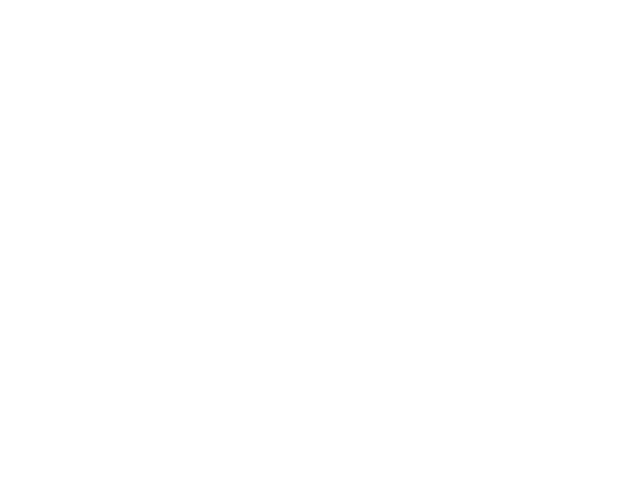

<Figure size 640x480 with 0 Axes>

In [16]:
from flask import Flask, render_template, request, send_file
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import io
import base64
img_stream = io.BytesIO()
plt.savefig(img_stream, format='png')
img_stream.seek(0)
img_data = img_stream.getvalue()
# Convertir le graphique en secteur en base64
img_data_base64 = base64.b64encode(img_data).decode('utf-8')

# Construire la balise img avec la source base64
img_html = f'<img src="data:image/png;base64,{img_data_base64}" alt="Pie Chart">'

print(img_html)

In [22]:
filtered_data = df_final.copy()
    # Prendre un échantillon après filtrage
df_sample = filtered_data.sample(n=200, random_state=42) if len(filtered_data) > 1000 else filtered_data 
def generate_pie_chart():
    # Filtrer les données pour les personnes décédées
    df_deceased = df_sample[df_sample['nombre_personnes_decedees'] > 0]

    # Générer le graphique en secteur
    plt.figure(figsize=(7, 7))
    plt.pie(df_deceased.groupby('date')['nombre_personnes_decedees'].sum(),
            labels=df_deceased.groupby('date')['nombre_personnes_decedees'].sum().index,
            autopct='%1.1f%%', startangle=140)
    plt.title('Répartition des personnes décédées par année')
    plt.axis('equal')

    # Convertir le graphique en image pour l'afficher dans le template HTML
    img_stream = io.BytesIO()
    plt.savefig(img_stream, format='png', bbox_inches='tight')
    img_stream.seek(0)
    img_data = img_stream.getvalue()
    img_base64 = base64.b64encode(img_data).decode('utf-8')

    return f'<img src="data:image/png;base64,{img_base64}" alt="Pie Chart">'

print('<img src="data:image/png;base64,{img_base64}" alt="Pie Chart">')

<img src="data:image/png;base64,{img_base64}" alt="Pie Chart">


In [3]:

from flask import Flask, render_template, request
import folium
import io
import pandas as pd
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import base64
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from flask import Flask, send_from_directory
from datetime import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

def generate_graph_taux_reussite(filtered_data):
    plt.figure(figsize=(10, 6))
    
    # Calculer le taux de réussite par type de flotteur
    taux_reussite = filtered_data.groupby('categorie_flotteur')['operation_reussie'].mean() * 100
    
    ax = sns.barplot(x=taux_reussite.index, y=taux_reussite.values)
    plt.title('Taux de Réussite des Opérations par Type de Flotteur')
    plt.xlabel('Type de Flotteur')
    plt.ylabel('Taux de Réussite (%)')
    
    # Ajouter des étiquettes de données au-dessus des barres
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.1f') + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize=10, color='black')
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join('static', 'modal-taux-reussite.png'))
    plt.close()
    print(generate_graph_taux_reussite)

In [4]:



from flask import Flask, render_template, request
import folium
import io
import pandas as pd
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import base64
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from flask import Flask, send_from_directory
from datetime import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

plt.figure(1)
plt.pie(x = [25285,14255,15225,12670,13905,16500], labels = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June'],
           colors = ['#5830f3', '#7644e3', '#16369b', '#16e5cb', '#7ecff1','#c7d8f0'],
           autopct = lambda x: str(round(x, 2)) + '%')
plt.legend()